# Определение возраста покупателей

## Исследовательский анализ данных

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [ ]:
%%time 
datagen = ImageDataGenerator(rescale = 1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory = '/datasets/faces/final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size =(224, 224),
        batch_size = 32,
        class_mode = 'raw',
        seed = 12345)

features, target = next(gen_flow)


Found 7591 validated image filenames.
CPU times: user 704 ms, sys: 429 ms, total: 1.13 s
Wall time: 1min 13s


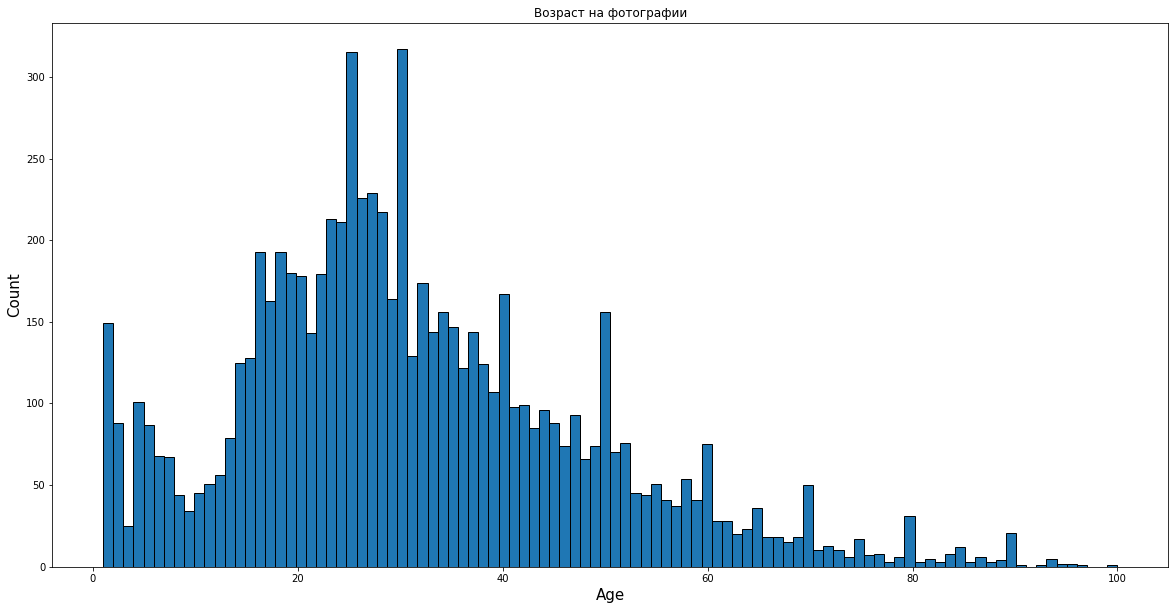

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(labels.real_age, edgecolor = 'black', bins = 100);
plt.xlabel('Age', fontsize = 15);
plt.ylabel('Count', fontsize = 15);
plt.title('Возраст на фотографии');

In [ ]:
print(f'максимальный возраст: {np.max(target)}',
      f'минимальный возраст: {np.min(target)}',
      f'средний возраст: {np.mean(target)}',
      f'медианный возраст: {np.median(target)}', sep = '\n')

максимальный возраст: 94
минимальный возраст: 4
средний возраст: 35.46875
медианный возраст: 31.0


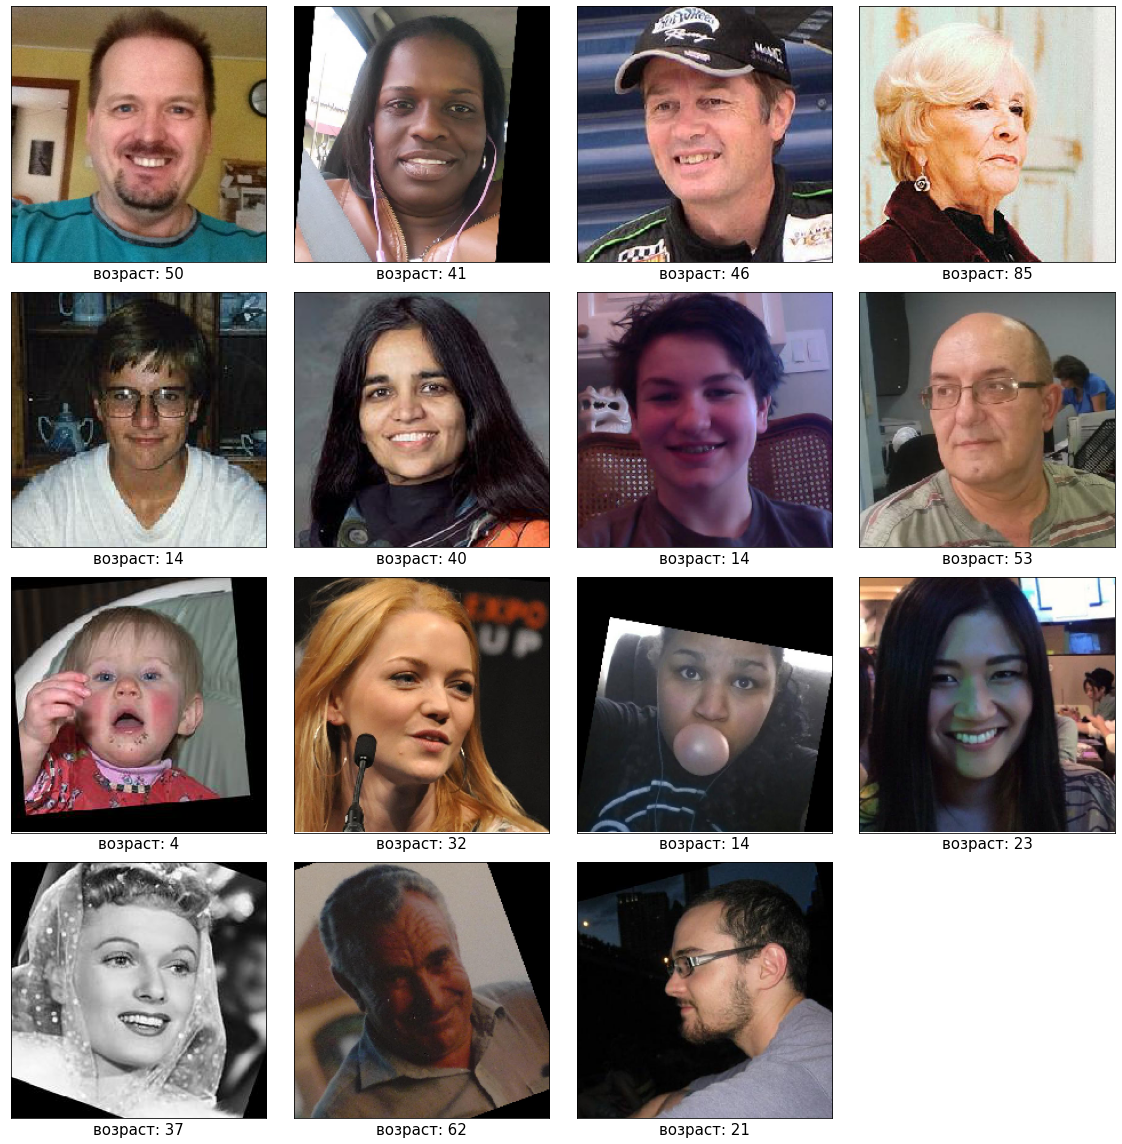

In [ ]:
age = target[:15]
fig = plt.figure(figsize = (16, 16))
for i in range(15):
    fig.add_subplot(4,4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.xlabel(f'возраст: {age[i]}', fontsize = 15)
    plt.yticks([])
    plt.tight_layout()

# Промежуточный вывод
 - просмотрев картинки мы с вами видим что у нас есть развернутые картинки а так же черно белые картинки, так же у нас есть фотографии которые сделанные с поворотами(боком), есть профильные фотографии, так же мы видим что контрастность изображений разная и некоторые изображения у нас находится под углом.
 - видим широкий разброс возраста ( у нас есть как дети так и взрослые), минимальный возраст 4 , а самый максимальный возраст 94
 - большая часть фото сконентрирована в медианном значении 31, означает что 50 процентов наших данных находится ниже этого возраста и 50 процентов больше
 - рекомендованные аугментации, поворот по горизонтали. ( так же можно еще "поиграться" с контрастностью)

## Обучение модели

```python
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_data = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=12345)
    return train_data

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_data = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_data

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    classes = 1000,
                    include_top= False
                    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model


def train_model(model, 
                train_data,
                test_data,
                batch_size=None,
                epochs=10,
                steps_per_epoch=None,
                validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
```

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-04-11 11:02:37.057702: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-11 11:02:37.609127: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 60s - loss: 203.0260 - mae: 10.6734 - val_loss: 455.5340 - val_mae: 16.1805
Epoch 2/10
178/178 - 41s - loss: 96.6529 - mae: 7.4320 - val_loss: 481.6674 - val_mae: 18.8861
Epoch 3/10
178/178 - 42s - loss: 61.5492 - mae: 5.9585 - val_loss: 369.1799 - val_mae: 14.2797
Epoch 4/10
178/178 - 44s - loss: 41.7687 - mae: 4.9449 - val_loss: 201.9193 - val_mae: 10.5932
Epoch 5/10
178/178 - 43s - loss: 31.3462 - mae: 4.2999 - val_loss: 106.9451 - val_mae: 8.0235
Epoch 6/10
178/178 - 44s - loss: 23.2802 - mae: 3.6985 - val_loss: 91.6857 - val_mae: 7.1506
Epoch 7/10
178/178 - 44s - loss: 17.8689 - mae: 3.2816 - val_loss: 91.0370 - val_mae: 7.0369
Epoch 8/10
178/178 - 43s - loss: 13.0447 - mae: 2.7796 - val_loss: 74.2604 - val_mae: 6.5349
Epoch 9/10
178/178 - 43s - loss: 10.1740 - mae: 2.4273 - val_loss: 80.1110 - val_mae: 6.9177
Epoch 10/10
178/178 - 44s - loss: 9.2271 - mae: 2.2952 - val_loss: 70.9831 - val_mae: 6.3461
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 70.9831 - mae: 6.3461
Test MAE: 6.3461

```

## Анализ обученной модели

# Вывод: 
 - Для обучения модели для предсказания возраста по фотографии мы использовали  ResNet50 со следующими параметрами:
   - архитектура которую использвали (бекбон + голова), загруженные веса - weights='imagenet'
   - размер батча = 32,
   - оптимизатор - Adam( lr = 0.0005)
   - поворот по горизонтали обучающая выборка
   - количество эпох = 11
   - заморозка весов бакбона не осуществлялась
   - при обучение на данных параметрах переобучения не наблюдалось
 - ИТОГ :
   - Добились результата mae = 6.34